## Capstone Jupyter Notebook
__Author: Sam Steffes__
<br>*Date: 08/18/2020*

This notebook will be used for the Coursera IBM Data Science Capstone project. This project will use data from previous vehicle collisions to try and build a machine learning model that predicts the severity of accidents based on given conditions.

_The data comes from collision records recorded by the Seattle Police Department from 2004 through May of 2020_

In [1]:
#import some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import the SDOT/SPD dataset on collisions between 2004 and 2020
df_csv = pd.read_csv('Data-collisions.csv')
df_csv.head()

c:\python\python384\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### 1.0 Data Exploration
We will do some preliminary examination of the dataset to:
 - understand the dataset (incl. the datatypes of different columns)
 - identify possible independent parameters that could be useful for the model
 - identify what data cleansing and pre-processing might be required
 
[Metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)

In [21]:
#what is the size of the dataset
print(df_csv.shape)

#severity code is the target/dependent variable... what is the breakdown of classifications in the dataset?
df_csv.value_counts('SEVERITYCODE')

coll_1 = df_csv[df_csv['SEVERITYCODE']==1].count()['SEVERITYCODE']
coll_2 = df_csv[df_csv['SEVERITYCODE']==2].count()['SEVERITYCODE']
print('Ratio of Collisions with property damage only to those with injuries: '+'{:.2f}'.format(coll_1/coll_2))

(194673, 38)
Ratio of Collisions with property damage only to those with injuries: 2.35


In [11]:
#we can see that the dataset has almost 200k samples and 38 rows.. also there are almost 2.5x the number of
#collisions affecting property as there are collisions with injuries

#what are the different columns that exist in the dataset?
df_csv.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

After reviewing the columns and metadata, the following look like good candidates for predicting severity (ie they might influence it):

|Column Name|Description|Possible Application/Value/Impact to model|
|:---|:---|:---|
|COLLISIONTYPE|A keyword describing the collision, eg 'head-on', 'angled', 'cycles', etc.|The orientation or nature of the collision could be valuable to the likelihood of injury to people involved.|
|PERSONCOUNT|Total number of people involved in the collision. |More people involved in the collision means more chances for injuries... people could be seated in the vehicle in locations were more succeptible, etc.|
|PEDCOUNT|The number of pedestrians involved in the collision.|Pedestrians are at greater risk of injury when struck by vehicles or bicycles.|
|PEDCYLCOUNT|The number of bicycles involved.|Bicyclists are at greater risk of injury when struck by vehicles.|
|VEHCOUNT|The number of vehicles involved in the collision.|More vehicles are more chances for injury, and might suggest more extensive impact, damage or severity.|
|INCDATE/INCDTTM|Date and time recordings for the incident records.|This is not as clear; however, the date or time that an incident occurs may be a proxy for driving behaviours that result in more severe incidents. For example, the are higher traffic volumes during weekday rushhours, and people are in a hurry or distracted.|
|INATTENTIONIND|If collision was due to inattention.|Distracted driving certainly increases the probabibily of getting in an accident, and may affect severity as well.|
|UNDERINFL|If driver was under influence of drugs/alchohol.|Someone under the influence might be driving recklessly, causing the collision to be more severe, and may also not be wearing the seatbelt or more succeptible to injury.|
|WEATHER|Weather at the time of incident.|Weather could have contributed to the nature of the collision, or the control of the vehicles before and after the collision.|
|ROADCOND|Condition of road at the time of incident.|This is probably closely aligned with weather, but could also capture the maintenance condition of the roadway.|
|LIGHTCOND|Light conditions at the time of incident.|Poor visibility may have contributed to the collision, especially where there are already blind or hidden turns, difficult or dangerous maneuvers are required, or acceptable speeds are high.|
|SPEEDING|If speeding was a factor in the collision.|Speeding or reckless driving could result in more forceful collisions.|

Lets explore each of the columns.

In [88]:
#first lets look at the two date/time columns for format, samples, etc.

print(df_csv[['INCDATE','INCDTTM']].dtypes)

print(df_csv[['INCDATE','INCDTTM']].describe())

df_csv[['INCDATE','INCDTTM']].head(20)

INCDATE    object
INCDTTM    object
dtype: object
                       INCDATE    INCDTTM
count                   194673     194673
unique                    5985     162058
top     2006/11/02 00:00:00+00  11/2/2006
freq                        96         96


,INCDATE,INCDTTM
0,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM
5,2019/04/20 00:00:00+00,4/20/2019 5:42:00 PM
6,2008/12/09 00:00:00+00,12/9/2008
7,2020/04/15 00:00:00+00,4/15/2020 5:47:00 PM
8,2006/06/15 00:00:00+00,6/15/2006 1:00:00 PM
9,2006/03/20 00:00:00+00,3/20/2006 3:49:00 PM


In [89]:
#the format for both columns is 'object' and not the datetime type that we would like and there are issues with the timestamp
#this may be and issue, but lets leave for now

#lets look at the volume of incidents overtime... first we need to convert the time the right format.
#lets use the INCDTTM column since that atleast captures the time for some records
df_csv['DATETIME']=df_csv['INCDTTM'].astype('datetime64[ns]')
print(df_csv['DATETIME'].dtypes)
print(df_csv['DATETIME'].describe())
df_csv[['DATETIME']].head(15)

datetime64[ns]
count                  194673
unique                 162058
top       2006-11-02 00:00:00
freq                       96
first     2004-01-01 00:00:00
last      2020-05-20 00:00:00
Name: DATETIME, dtype: object


<ipython-input-89-3125f7f008af>:8: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_csv['DATETIME'].describe())


,DATETIME
0,2013-03-27 14:54:00
1,2006-12-20 18:55:00
2,2004-11-18 10:20:00
3,2013-03-29 09:26:00
4,2004-01-28 08:04:00
5,2019-04-20 17:42:00
6,2008-12-09 00:00:00
7,2020-04-15 17:47:00
8,2006-06-15 13:00:00
9,2006-03-20 15:49:00


In [109]:
#group the incidents by year and severity classifiation for plotting
df_annual = df_csv.groupby([df_csv.DATETIME.dt.year,'SEVERITYCODE']).size().unstack(fill_value=0)
df_annual.head()

SEVERITYCODE,1,2
DATETIME,,
2004,8218,3647
2005,10665,4450
2006,10838,4350
2007,10439,4017
2008,9893,3767


In [110]:
#reformat the dataframe
df_annual.reset_index(drop=False,inplace=True)
df_annual.columns = ['Year','Property','Injury']
df_annual.head()

,Year,Property,Injury
0,2004,8218,3647
1,2005,10665,4450
2,2006,10838,4350
3,2007,10439,4017
4,2008,9893,3767


In [111]:
#lets add a Total colum to sum the number of total incidents per year, and calculate the fraction that are severe
df_annual['Total'] = df_annual['Property'] + df_annual['Injury']
df_annual['Severe_rate'] = df_annual['Injury'] / df_annual['Total']
#drop the 2020 row since the year is not complete... we want to look at the recent trend
df_annual.drop(df_annual.tail(1).index,inplace=True)
df_annual.tail()

,Year,Property,Injury,Total,Severe_rate
11,2015,9243,3752,12995,0.288726
12,2016,7945,3714,11659,0.318552
13,2017,7454,3419,10873,0.314449
14,2018,7061,3358,10419,0.322296
15,2019,6350,3062,9412,0.325329


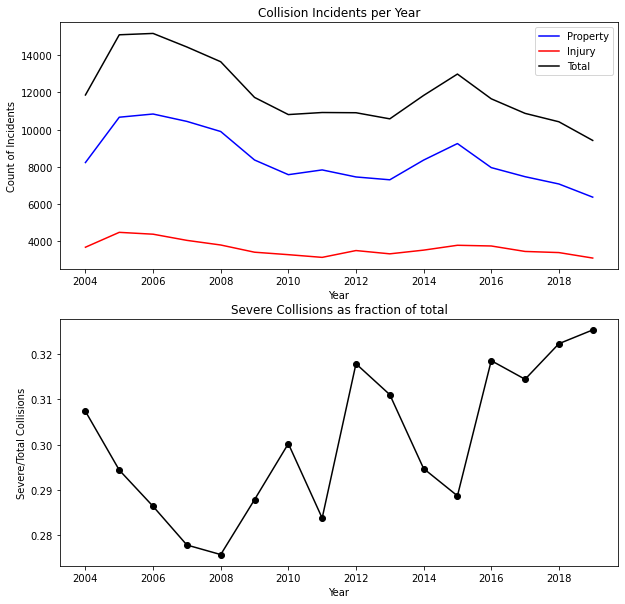

In [113]:
#lets plot the property and injury counts and rate of severe (injury) collisions versus year
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1.plot('Year','Property',data=df_annual,marker='',color='blue')
ax1.plot('Year','Injury',data=df_annual,marker='',color='red')
ax1.plot('Year','Total',data=df_annual,marker='',color='k')
ax1.set(title='Collision Incidents per Year',xlabel = 'Year',ylabel='Count of Incidents')
ax1.legend()

ax2.plot('Year','Severe_rate',data=df_annual,marker='o',color='k')
ax2.set(title='Severe Collisions as fraction of total',xlabel='Year',ylabel='Severe/Total Collisions')

plt.show()

__This is an interesting observation, and perhaps forms the business case for building a model to predict collision severity.__

In the Spring of 2015, the Seattle Department of Transportation published a 10-year Strategic Vision for sustainable and safe transportation in the city.

[Webpage & Report Link](https://www.seattle.gov/transportation/document-library/citywide-plans/move-seattle)

The report highlights the city's **_Vision Zero_** goal of eliminating serious and fatal crashes by 2030. As we can see from the above chart, while the number of total incidents has decreased every year since 2015, the number of incidents where injuries occur has stayed mostly flat, accounting for a higher percentage of the total volume.

Building a model to predict the severity of collisions could benefit the Seattle DOT in a couple ways:

 - identifying the factors that most contribute to severe collisions, allowing more targetted improvements and changes
 - providing a means to quantify (evaluate) and select improvements options with the most benefit (reduction in severe incidents)
 - allow coordination with emergency response services on resource optimization and development of decision-support tools for dispatching (where response is most critical, etc).

In [115]:
#lets keep exploring the data.. for simplicity, lets create a new df with the features that we want only

df_exp = df_csv[['DATETIME','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INATTENTIONIND','UNDERINFL',
                'WEATHER','ROADCOND','LIGHTCOND','SPEEDING','SEVERITYCODE']]
print(df_exp.shape)
df_exp.head()

(194673, 13)


,DATETIME,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
0,2013-03-27 14:54:00,Angles,2,0,0,2,NaN,N,Overcast,Wet,Daylight,NaN,2
1,2006-12-20 18:55:00,Sideswipe,2,0,0,2,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,1
2,2004-11-18 10:20:00,Parked Car,4,0,0,3,NaN,0,Overcast,Dry,Daylight,NaN,1
3,2013-03-29 09:26:00,Other,3,0,0,3,NaN,N,Clear,Dry,Daylight,NaN,1
4,2004-01-28 08:04:00,Angles,2,0,0,2,NaN,0,Raining,Wet,Daylight,NaN,2
